# Modelo De Predição de valores de algueis de apartamentos na Cidade de curitiba
# Base de dados reais obtidos através de webscraping no site Viva Real no dia 24_09_2023

In [102]:
# bibliotecas utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import os

#Desativando warnings
import warnings
warnings.filterwarnings('ignore')


In [103]:
# Carregando todos os .csv na pasta bases em um dataframe
path = 'bases/'

dataframes = []

for file in os.listdir(path):
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path,sep=';')
        df['cidade'] = file.split('_')[1].replace(' ','')
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Carregando apenas cidade de Curitiba
# df = pd.read_csv('bases/vivareal_curitiba _20230924.csv',sep=';')

In [104]:
# Informacoes basicas sobre a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232316 entries, 0 to 232315
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   descricao   229339 non-null  object 
 1   endereco    232316 non-null  object 
 2   area        232316 non-null  object 
 3   quartos     232316 non-null  object 
 4   suites      232316 non-null  object 
 5   wc          232316 non-null  object 
 6   vagas       232316 non-null  object 
 7   valor       232316 non-null  int64  
 8   condominio  232316 non-null  object 
 9   w_link      232316 non-null  object 
 10  tipo        232316 non-null  object 
 11  cep         232313 non-null  float64
 12  lat         232316 non-null  object 
 13  lon         232316 non-null  object 
 14  cidade      232316 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 26.6+ MB


In [105]:
# Verificar a distribuição de valores

df['tipo'].value_counts( normalize=True) * 100

tipo
APARTMENT                     38.907781
OFFICE                        19.469602
BUSINESS                      12.888479
HOME                          12.410252
SHED_DEPOSIT_WAREHOUSE         4.583843
COMMERCIAL_PROPERTY            2.746690
CONDOMINIUM                    1.414453
COMMERCIAL_BUILDING            1.284027
FLAT                           1.209559
COMMERCIAL_ALLOTMENT_LAND      1.018440
PENTHOUSE                      0.987018
RESIDENTIAL_ALLOTMENT_LAND     0.882419
BUILDING                       0.877684
KITNET                         0.698187
ALLOTMENT_LAND                 0.314227
RESIDENTIAL_BUILDING           0.081355
FARM                           0.050793
LOFT                           0.049071
CLINIC                         0.035727
PARKING_SPACE                  0.031853
VILLAGE_HOUSE                  0.024105
TWO_STORY_HOUSE                0.018940
HOTEL                          0.015496
Name: proportion, dtype: float64

In [106]:
# Criando um dataframe apenas de apartamentos e com a cidade de São Paulo

df_apartament = df[(df['tipo'] == 'APARTMENT') & (df['cidade'] == 'sãopaulo')]
df_apartament.drop_duplicates(inplace=True)
print(f'Quantidade de Registros: {len(df_apartament)}')

Quantidade de Registros: 6247


In [107]:
# Verificando valores nulos
df_apartament.isnull().sum()

descricao     3
endereco      0
area          0
quartos       0
suites        0
wc            0
vagas         0
valor         0
condominio    0
w_link        0
tipo          0
cep           0
lat           0
lon           0
cidade        0
dtype: int64

In [108]:
# Função para substituir '-' por 0 e converter para int ou float
def replace_dash_with_zero(value):
    if value == '-':
        return 0
    else:
        try:
            return int(value)
        except ValueError:
            try:
                return float(value)
            except ValueError:
                return value

# Aplicar a função em todas as células do DataFrame
df_apartament = df_apartament.applymap(replace_dash_with_zero)


In [109]:
# Separando as colunas numéricas do dataframe

colunas_numericas = df_apartament.select_dtypes(include=['int64']).columns
colunas_numericas = colunas_numericas.drop('cep')

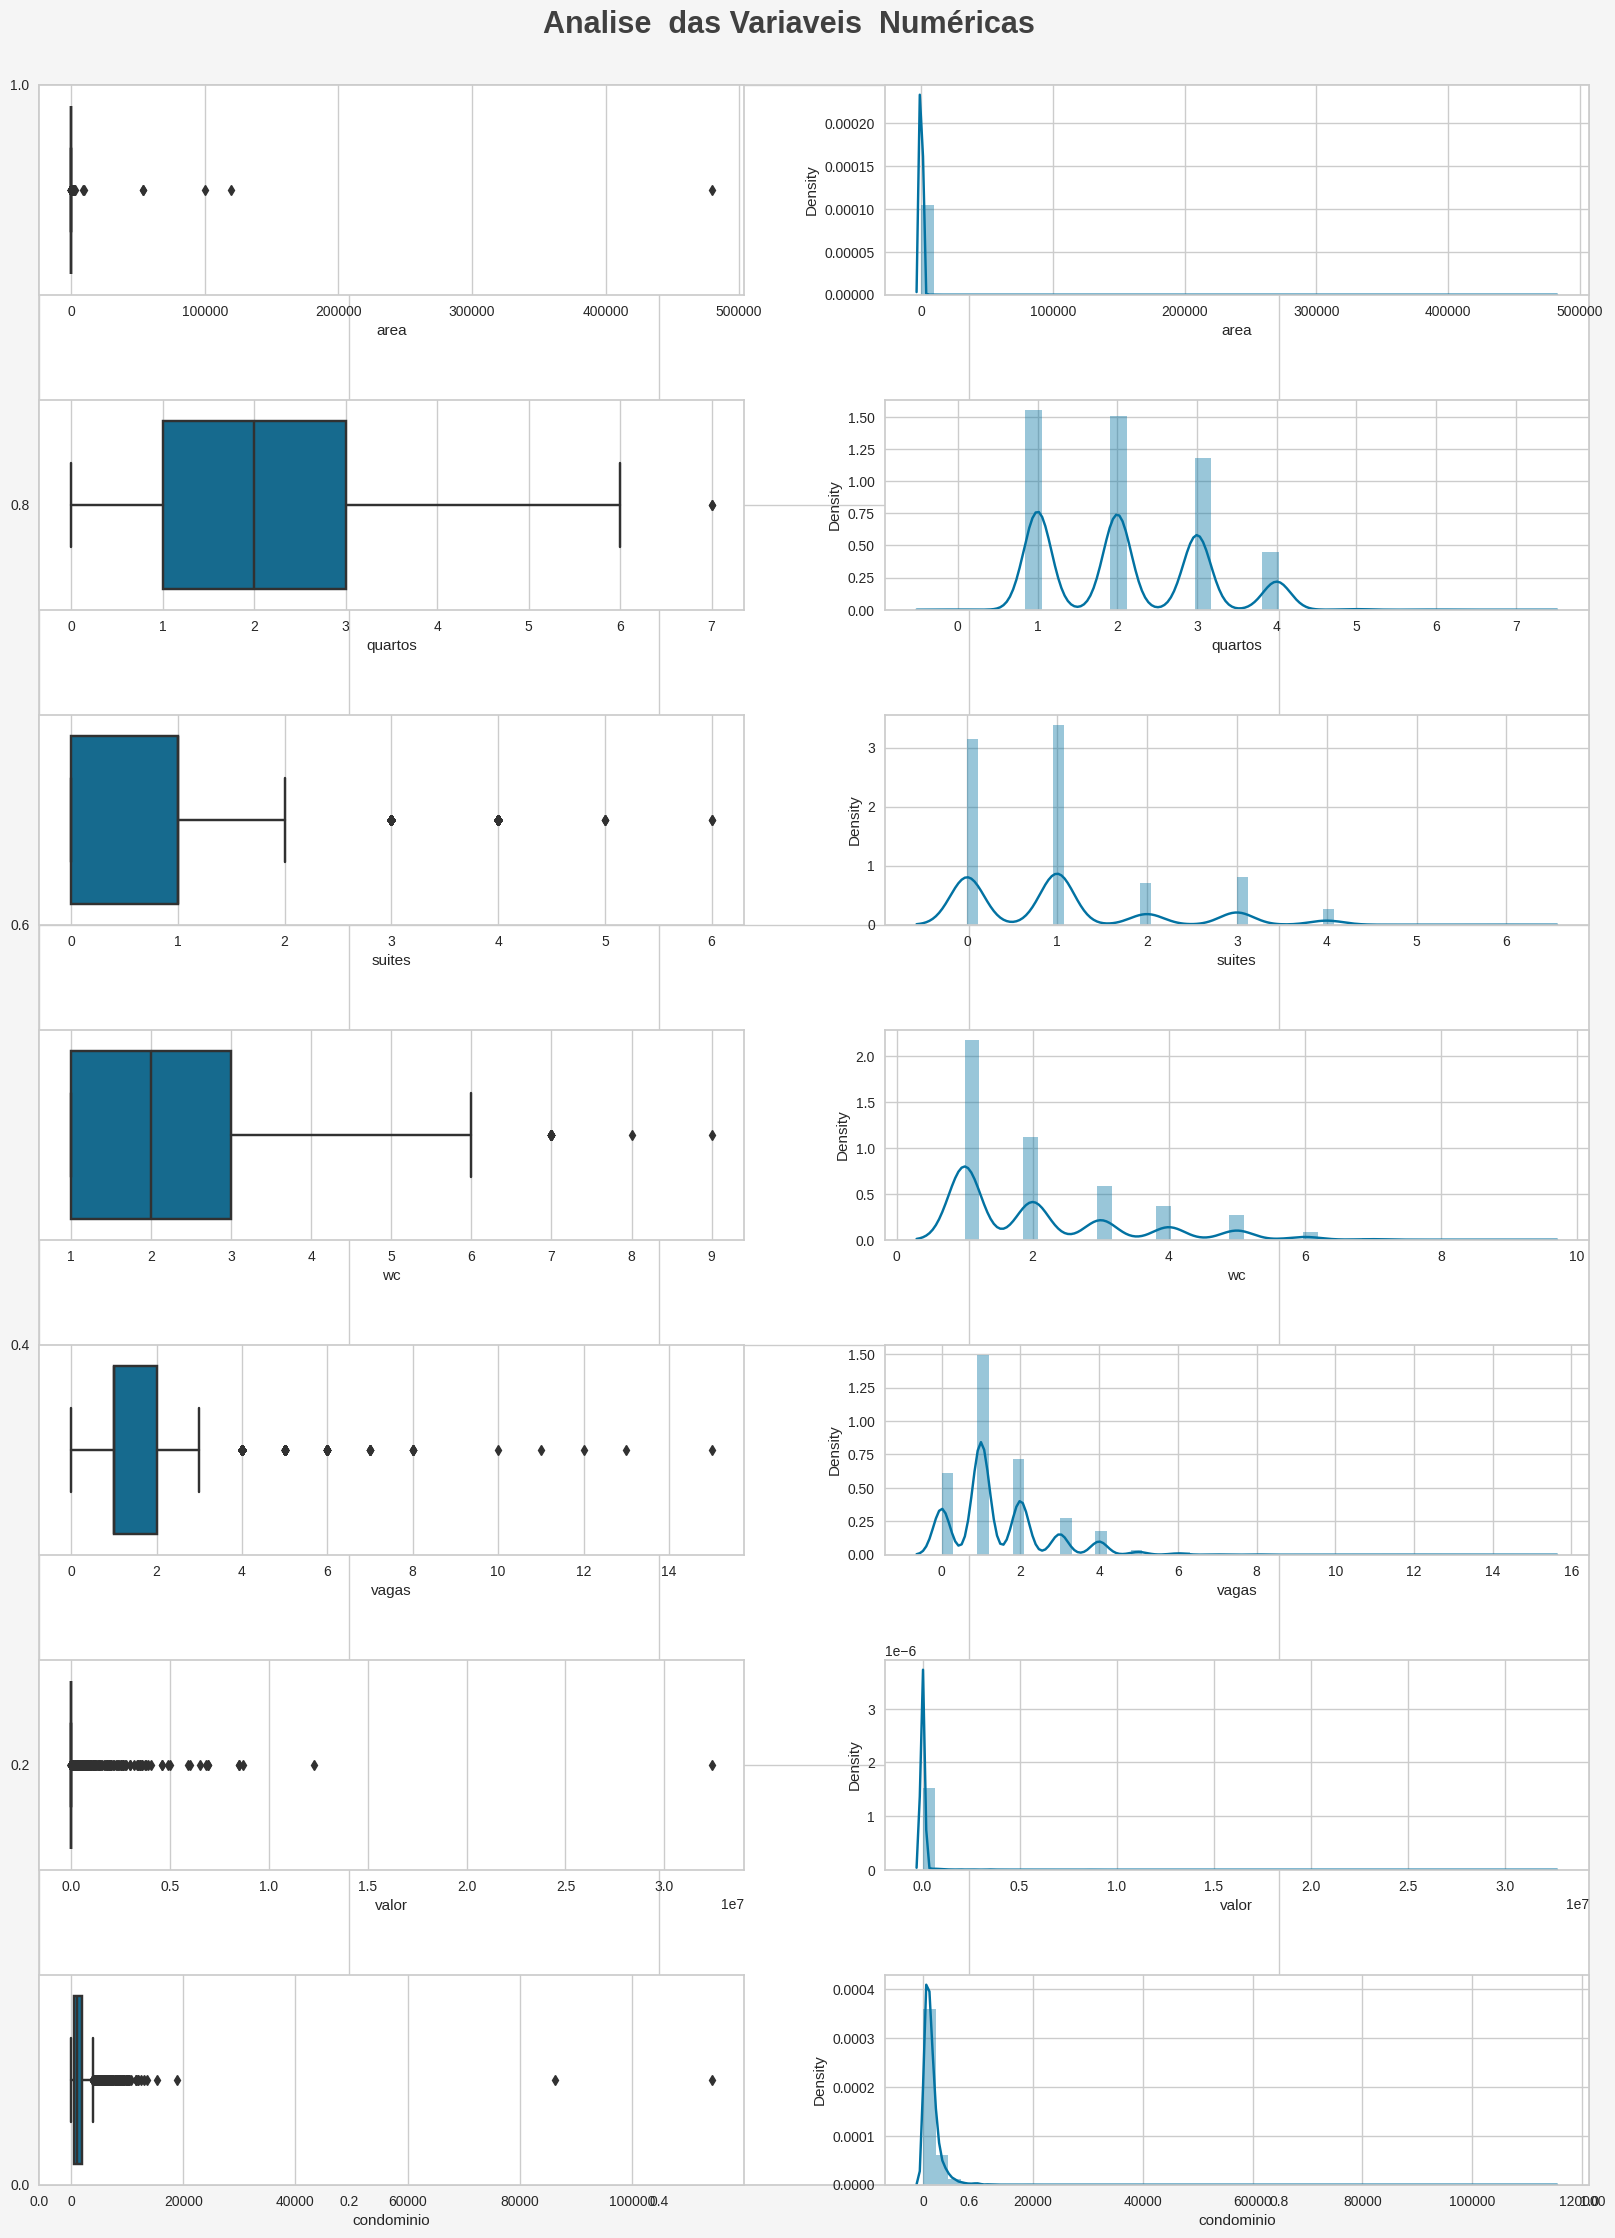

In [110]:
# Criando gráficos para analisar dados numéricos

# Tamanho

figura,eixo = plt.subplots( figsize = (20,25))

# Cor de fundo
cor_fundo = '#F5F5F5'
figura.set_facecolor(cor_fundo)

#Paleta de cores
paleta_cores =  sns.color_palette('flare', len(colunas_numericas) *2)

# Titulo
plt.suptitle ('Analise  das Variaveis  Numéricas' , fontsize = 22 , color = '#404040', fontweight = 600) 

# Estrutura
linhas = 7
colunas = 2
posicao = 1

for coluna in colunas_numericas:

    plt.subplot( linhas, colunas, posicao )
    
    # Plot
    sns.boxplot( data = df_apartament , x = coluna )
    
    posicao += 1
    
    plt.subplot( linhas , colunas , posicao )

    # Plot 
    
    sns.distplot( df_apartament[coluna] )

    posicao += 1

# Ajuste de grid

plt.subplots_adjust( top = 0.95 , hspace = 0.5)

In [111]:
# Analisando variaveis estatisticas de cada coluna

df_apartament['valor'].describe().astype(int)

count        6247
mean        57322
std        586372
min           560
25%          2230
50%          4150
75%          8000
max      32390000
Name: valor, dtype: int64

In [112]:
# Aplicando método IQR Score para identificar outliers

def metodo_quartil(variavel , dataframe):
    Q1 = df_apartament[variavel].quantile(0.25)
    Q3 = df_apartament[variavel].quantile(0.75)
    IQR = Q3 - Q1

    limite_superior = Q3 + 1.5 * IQR
    limite_inferior = Q1 - 1.5 * IQR


    print(f'Q1:{Q1}')
    print(f'Q3: {Q3}')
    print(f'IQR:{IQR}')
    print(f'Limite superior: {limite_superior}')
    print(f'Limite inferior: {limite_inferior}')

    # Removendo outliers
    dataframe = dataframe[(dataframe[variavel] < limite_superior) & (dataframe[variavel] > limite_inferior)]

    return dataframe

# Aplicando o método para cada coluna numérica
df_apartament = metodo_quartil('valor', df_apartament)

Q1:2230.0
Q3: 8000.0
IQR:5770.0
Limite superior: 16655.0
Limite inferior: -6425.0


In [113]:
# Resetando o index
df_apartament.reset_index(drop=True, inplace=True)

In [114]:
# Encontrando os maiores valores
df_apartament['valor'].nlargest(10)

2295    16500
5458    16499
677     16498
2628    16498
1500    16497
3904    16497
4996    16497
543     16496
910     16496
2058    16400
Name: valor, dtype: int64

In [115]:
# Separa a base
caracteristicas = df_apartament[['area' , 'quartos' , 'suites' , 'wc' , 'vagas' , 'condominio']]
previsor = df_apartament['valor']
caracteristicas.shape , previsor.shape

((5737, 6), (5737,))

In [116]:
# Analisando a correlação
# Proxima de 1 = forte correlação , ambos aumentam ou diminuem
# Proxima de -1 = forte correlação inversa , um aumenta o outro diminui
df_corr = df_apartament.drop(columns=['cep', 'lat', 'lon' ,'w_link' ,'descricao', 'endereco' , 'tipo','cidade'])
df_corr.corr()

,area,quartos,suites,wc,vagas,valor,condominio
area,1.000000,-0.003255,0.015225,0.000850,0.006641,0.026692,0.001525
quartos,-0.003255,1.000000,0.565745,0.730393,0.641237,0.504463,0.277951
suites,0.015225,0.565745,1.000000,0.756218,0.735925,0.662259,0.348434
wc,0.000850,0.730393,0.756218,1.000000,0.721664,0.639018,0.307534
vagas,0.006641,0.641237,0.735925,0.721664,1.000000,0.640601,0.355075
valor,0.026692,0.504463,0.662259,0.639018,0.640601,1.000000,0.319659
condominio,0.001525,0.277951,0.348434,0.307534,0.355075,0.319659,1.000000


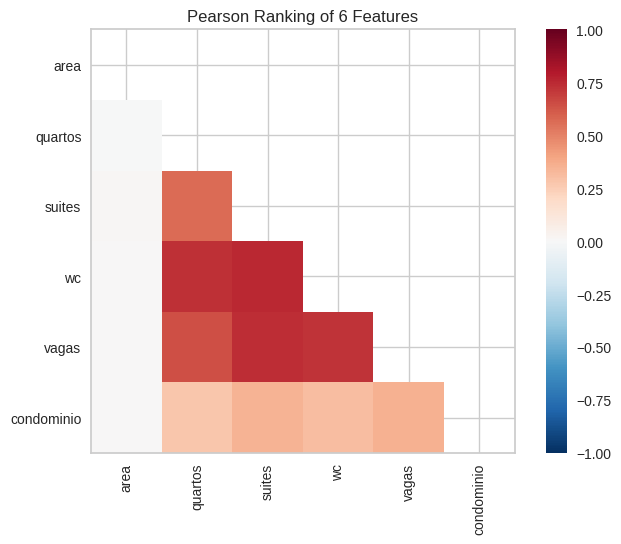

In [117]:
# Utilizando o yellowbrik
from yellowbrick.features import Rank2D

correlacao = Rank2D(algorithm='pearson')

correlacao.fit(caracteristicas, previsor)
correlacao.transform(caracteristicas)
correlacao.show();


In [118]:
# Separando a base entre treino e teste
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(
    caracteristicas,previsor, test_size=0.3, random_state=42
)

In [119]:
# Observando o tamanho das bases
print(f'Dados de treino: {x_treino.shape[0]}')
print(f'Dados de teste: {x_teste.shape[0]}')

Dados de treino: 4015
Dados de teste: 1722


In [120]:
# features mais relevante
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

def selecao_features (x_treino , y_treino):

    selecao = SelectKBest( score_func=mutual_info_regression, k = 'all')

    selecao.fit(x_treino, y_treino)

    return selecao

scores = selecao_features( x_treino, y_treino)

# Analisar o resultado

for posicao , score in enumerate(scores.scores_):
    print(f'{x_treino.columns[posicao]} : {score}')

area : 0.4862600183345962
quartos : 0.2136196995192159
suites : 0.32973371838481125
wc : 0.35527059113403014
vagas : 0.32957270564909846
condominio : 0.6067315287059776


In [121]:
# Construção do modelo
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

modelo_random_forest = RandomForestRegressor(max_depth=5)

modelo_random_forest.fit(x_treino, y_treino)

RandomForestRegressor(max_depth=5)

In [122]:
# Avaliar performance do modelo
previsoes = modelo_random_forest.predict(x_teste)


In [123]:
# Testando o modelo com 1 linha de dados

previsao = modelo_random_forest.predict(x_teste[1:2])
print(f'caracteristicas: {x_teste[1:2].values} || Valor real: {y_teste[1:2].values} || Previsão: {previsao}')

caracteristicas: [[ 275    4    2    5    4 3900]] || Valor real: [9997] || Previsão: [11162.71433598]


In [124]:
# Funcoes de metricas de resultado

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

print(f'RMSE: {sqrt(mean_squared_error(y_teste, previsoes))}'),
print(f'Score: {r2_score(y_teste, previsoes)}')

RMSE: 2288.991775809491
Score: 0.6076394979134921


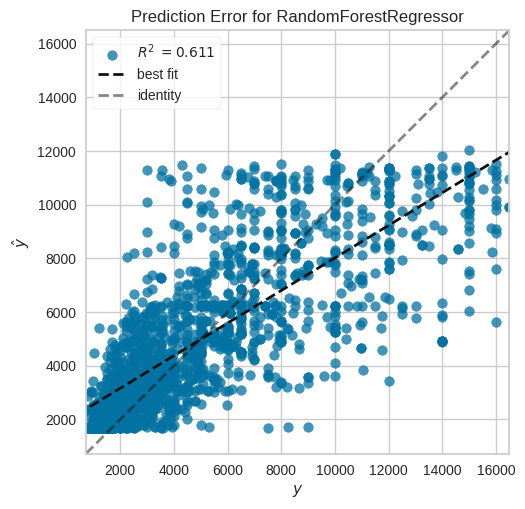

In [125]:
# Analisando o resultado com o preditor do yellowbrick

from yellowbrick.regressor import PredictionError

modelo = RandomForestRegressor(max_depth=5)
erro_modelo = PredictionError(modelo)

erro_modelo.fit(x_treino, y_treino)
erro_modelo.score(x_teste, y_teste)
erro_modelo.show();

In [ ]:
# Exportar modelo

import joblib
joblib.dump(modelo_random_forest, 'modelo_random_forest.pkl')

In [ ]:
# Carregar modelo

funcao_modelo = joblib.load('modelo_random_forest.pkl')
funcao_modelo

In [ ]:
# Testar modelo carregado

funcao_modelo.predict(x_teste.head(1).values)